## Displacement

In [62]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from model.Displacement.reconstruction import EncoderDecoder
from dataset.Displacement.DataReconstruction import DataReconstructionDataset
from torch.utils.data import DataLoader

In [63]:
def visualize_masked_process_reconstructions(fig, axes, masked_signal, prediction, target_signal, task, ylabel):

    target = [1, 1, 1, 1, 0] if task == "A" else [1, 1, 0, 0, 0]

    for id, m in enumerate(masked_signal):
        mask = []
        for row in range(5):
            unique = np.unique(m[row, :])
            if len(unique) == 1 and unique[0] == 0:
                mask.append(0)
            else:
                mask.append(1)
        if target == mask:
            break

    bs, num, length = target_signal.shape
    start = 0
    length = 200

    for i in range(num):
        if len(np.unique(masked_signal[id, i, :])) != 1:
            line1 = axes[i].plot(range(len(target_signal[id, i, start:start+length])), target_signal[id, i, start:start+length], color="tab:orange",  label="Original Signal")
            line2 = axes[i].plot(range(len(prediction[id, i, start:start+length])), prediction[id, i, start:start+length], color="tab:green", linestyle="--",  label="Reconstruction Signal")          
        else:
            line3 = axes[i].plot(range(len(target_signal[id, i, start:start+length])), target_signal[id, i, start:start+length], color="tab:blue",  label="Original Signal (Masked)")
            line4 = axes[i].plot(range(len(prediction[id, i, start:start+length])), prediction[id, i, start:start+length], color="tab:red", linestyle="--",  label="Reconstruction Signal  (Masked)") 
        

    fig.supylabel(ylabel, x=-0.02)
    fig.suptitle(f"Scenerio {task}", y = 0.92)
    fig.legend(handles =[line1[0], line2[0], line3[0], line4[0]], loc ='lower center', ncol=2)
    return fig

In [64]:
def denormalize(signal):
    min_max = pd.read_csv("./Data/Displacement/min_max.csv").values
    n = signal.shape[0]
    output_signal = torch.zeros_like(signal, dtype=torch.float32)
    for i in range(n):
        for j in range(5):
            output_signal[i, j, :] = signal[i, j, :] * (min_max[j][1] - min_max[j][0]) + min_max[j][0]

    return output_signal

In [65]:
mode = "test"
dataset = DataReconstructionDataset(path="./Data", mode=mode)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

In [66]:
scratch = EncoderDecoder.load_from_checkpoint("./Logs/Reconstruction/Displacement-EncoderDecoder/From_scratch/version_0/checkpoints/epoch=00491-val_loss=0.0010.ckpt").eval().to("cuda")
transfer_AE = EncoderDecoder.load_from_checkpoint("./Logs/Reconstruction/Displacement-EncoderDecoder/Transfer_AE/version_0/checkpoints/epoch=00496-val_loss=0.0016.ckpt").eval().to("cuda")
transfer_DamageAE = EncoderDecoder.load_from_checkpoint("./Logs/Reconstruction/Displacement-EncoderDecoder/Transfer_DamageAE/version_0/checkpoints/epoch=00494-val_loss=0.0016.ckpt").eval().to("cuda")
transfer_TripletAE = EncoderDecoder.load_from_checkpoint("./Logs/Reconstruction/Displacement-EncoderDecoder/Transfer_TripletAE/version_0/checkpoints/epoch=00496-val_loss=0.0016.ckpt").eval().to("cuda")

In [67]:
original_signal = []
masked_signal = []

scratch_prediction = []
AE_prediction = []
dAE_prediction = []
tAE_prediction = []

for masked_input, original_input in dataloader:
    with torch.no_grad():
        masked_input = masked_input.to("cuda")       
        scratch_prediction += scratch(masked_input).unsqueeze(0)
        AE_prediction += transfer_AE(masked_input).unsqueeze(0)
        dAE_prediction += transfer_DamageAE(masked_input).unsqueeze(0)
        tAE_prediction += transfer_TripletAE(masked_input).unsqueeze(0)

        original_signal += original_input.unsqueeze(0)
        masked_signal += masked_input.unsqueeze(0)


masked_signal = torch.concat(masked_signal).cpu()
original_signal = torch.concat(original_signal).cpu()
scratch_prediction = torch.concat(scratch_prediction).cpu()
AE_prediction = torch.concat(AE_prediction).cpu()
dAE_prediction = torch.concat(dAE_prediction).cpu()
tAE_prediction = torch.concat(tAE_prediction).cpu()

In [68]:
original_signal = denormalize(original_signal)
scratch_prediction = denormalize(scratch_prediction)
AE_prediction = denormalize(AE_prediction)
dAE_prediction = denormalize(dAE_prediction)
tAE_prediction = denormalize(tAE_prediction)

In [69]:
import torch.nn as nn
mean_squared_error = nn.MSELoss()
mse_scratch = mean_squared_error(original_signal, scratch_prediction)
mse_AE = mean_squared_error(original_signal, AE_prediction)
mse_dAE = mean_squared_error(original_signal, dAE_prediction)
mse_tAE = mean_squared_error(original_signal, tAE_prediction)
print(f"MSE from scrtach: {mse_scratch:.3E}")
print(f"MSE from AE: {mse_AE:.3E}")
print(f"MSE from DamageAE: {mse_dAE:.3E}")
print(f"MSE from TripletAE: {mse_tAE:.3E}")

rmse_scratch = torch.sqrt(mse_scratch)
rmse_AE = torch.sqrt(mse_AE)
rmse_dAE = torch.sqrt(mse_dAE)
rmse_tAE = torch.sqrt(mse_tAE)

print(f"RMSE from scrtach: {rmse_scratch:.3E}")
print(f"RMSE from AE: {rmse_AE:.3E}")
print(f"RMSE from DamageAE: {rmse_dAE:.3E}")
print(f"RMSE from TripletAE: {rmse_tAE:.3E}")

nrmse_scratch = rmse_scratch / (original_signal.max() - original_signal.min())
nrmse_AE = rmse_AE / (original_signal.max() - original_signal.min())
nrmse_dAE = rmse_dAE / (original_signal.max() - original_signal.min())
nrmse_tAE = rmse_tAE / (original_signal.max() - original_signal.min())

print(f"NRMSE from scrtach: {nrmse_scratch*100:.2f} %")
print(f"NRMSE from AE: {nrmse_AE*100:.2f} %")
print(f"NRMSE from DamageAE: {nrmse_dAE*100:.2f} %")
print(f"NRMSE from TripletAE: {nrmse_tAE*100:.2f} %")

MSE from scrtach: 4.149E-04
MSE from AE: 6.441E-04
MSE from DamageAE: 6.636E-04
MSE from TripletAE: 6.530E-04
RMSE from scrtach: 2.037E-02
RMSE from AE: 2.538E-02
RMSE from DamageAE: 2.576E-02
RMSE from TripletAE: 2.555E-02
NRMSE from scrtach: 2.68 %
NRMSE from AE: 3.35 %
NRMSE from DamageAE: 3.40 %
NRMSE from TripletAE: 3.37 %


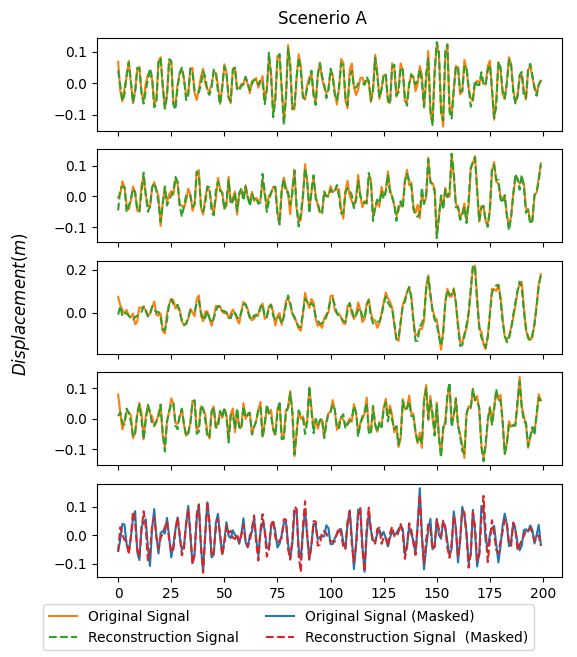

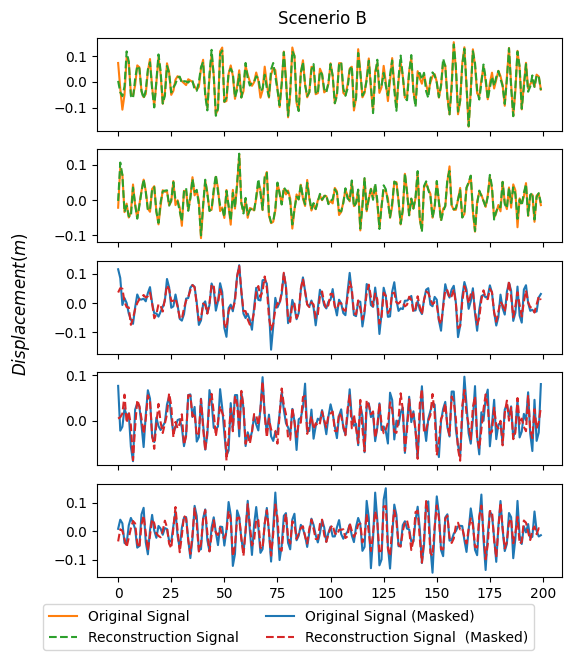

In [70]:
fig, axes = plt.subplots(5, 1, figsize=(6,7), sharex=True)
fig = visualize_masked_process_reconstructions(fig, axes, masked_signal, scratch_prediction, original_signal, "A", r"$Displacement (m)$")
plt.savefig("Scenerio A(disp).svg", bbox_inches="tight")
fig, axes = plt.subplots(5, 1, figsize=(6,7), sharex=True)
fig = visualize_masked_process_reconstructions(fig, axes, masked_signal, scratch_prediction, original_signal, "B", r"$Displacement (m)$")
plt.savefig("Scenerio B(disp).svg", bbox_inches="tight")

## Acceleration

In [71]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from model.Acceleration.reconstruction import EncoderDecoder
from dataset.Acceleration.DataReconstruction import DataReconstructionDataset
from torch.utils.data import DataLoader

In [72]:
def denormalize(signal):
    min_max = pd.read_csv("./Data/Acceleration/min_max.csv").values
    n = signal.shape[0]
    output_signal = torch.zeros_like(signal, dtype=torch.float32)
    for i in range(n):
        for j in range(5):
            output_signal[i, j, :] = signal[i, j, :] * (min_max[j][1] - min_max[j][0]) + min_max[j][0]

    return output_signal

In [73]:
mode = "test"
dataset = DataReconstructionDataset(path="./Data", mode=mode)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

In [74]:
scratch = EncoderDecoder.load_from_checkpoint("./Logs/Reconstruction/Acceleration-EncoderDecoder/From_scratch/version_0/checkpoints/epoch=00498-val_loss=0.0020.ckpt").eval().to("cuda")
transfer_AE = EncoderDecoder.load_from_checkpoint("./Logs/Reconstruction/Acceleration-EncoderDecoder/Transfer_AE/version_0/checkpoints/epoch=00499-val_loss=0.0029.ckpt").eval().to("cuda")

In [75]:
original_signal = []
masked_signal = []

scratch_prediction = []
AE_prediction = []
dAE_prediction = []
tAE_prediction = []

for masked_input, original_input in dataloader:
    with torch.no_grad():
        masked_input = masked_input.to("cuda")       
        scratch_prediction += scratch(masked_input).unsqueeze(0)
        AE_prediction += transfer_AE(masked_input).unsqueeze(0)

        original_signal += original_input.unsqueeze(0)
        masked_signal += masked_input.unsqueeze(0)


masked_signal = torch.concat(masked_signal).cpu()
original_signal = torch.concat(original_signal).cpu()
scratch_prediction = torch.concat(scratch_prediction).cpu()
AE_prediction = torch.concat(AE_prediction).cpu()

In [76]:
original_signal = denormalize(original_signal)
scratch_prediction = denormalize(scratch_prediction)
AE_prediction = denormalize(AE_prediction)

In [77]:
import torch.nn as nn
mean_squared_error = nn.MSELoss()
mse_scratch = mean_squared_error(original_signal, scratch_prediction)
mse_AE = mean_squared_error(original_signal, AE_prediction)
print(f"MSE from scrtach: {mse_scratch:.3E}")
print(f"MSE from AE: {mse_AE:.3E}")

rmse_scratch = torch.sqrt(mse_scratch)
rmse_AE = torch.sqrt(mse_AE)

print(f"RMSE from scrtach: {rmse_scratch:.3E}")
print(f"RMSE from AE: {rmse_AE:.3E}")

nrmse_scratch = rmse_scratch / (original_signal.max() - original_signal.min())
nrmse_AE = rmse_AE / (original_signal.max() - original_signal.min())

print(f"NRMSE from scrtach: {nrmse_scratch*100:.2f} %")
print(f"NRMSE from AE: {nrmse_AE*100:.2f} %")

MSE from scrtach: 3.829E-05
MSE from AE: 5.930E-05
RMSE from scrtach: 6.188E-03
RMSE from AE: 7.701E-03
NRMSE from scrtach: 2.86 %
NRMSE from AE: 3.56 %


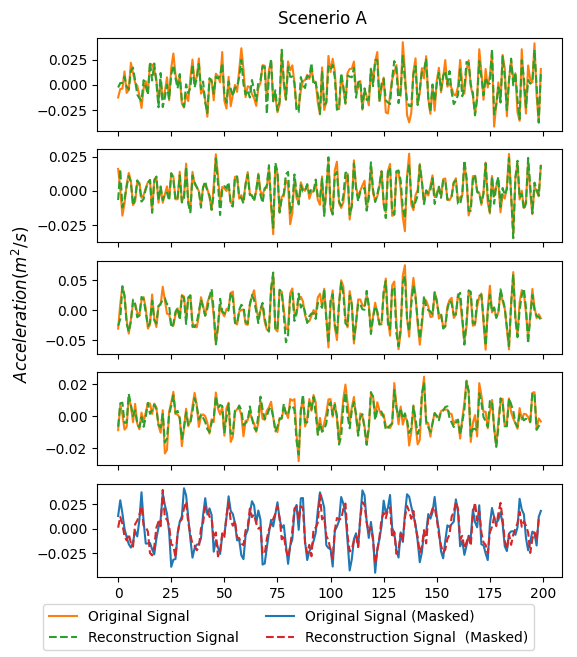

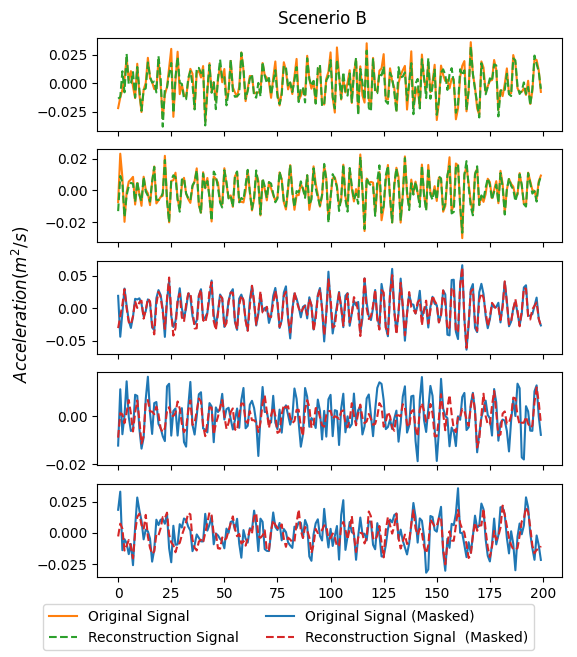

In [78]:
fig, axes = plt.subplots(5, 1, figsize=(6,7), sharex=True)
fig = visualize_masked_process_reconstructions(fig, axes, masked_signal, scratch_prediction, original_signal, "A", r"$Acceleration (m^2/s)$")
plt.savefig("Scenerio A(accel).svg", bbox_inches="tight")
fig, axes = plt.subplots(5, 1, figsize=(6,7), sharex=True)
fig = visualize_masked_process_reconstructions(fig, axes, masked_signal, scratch_prediction, original_signal, "B", r"$Acceleration (m^2/s)$")
plt.savefig("Scenerio B(accel).svg", bbox_inches="tight")